In [13]:
import pandas as pd
import yfinance as yf

In [12]:
!pip install yfinance

  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.


In [14]:
df_yahoo = yf.download('AAPL', start='2000-01-01', end='2010-12-31', progress=False)

In [16]:
df_yahoo.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.855796,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.783644,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.795111,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.726304,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.760708,460734400


# 라이브러리 - download 함수
- 복수개의 티커를 전달할 수 있다. ex)['AAPL', 'MSFT']
- auto_adjust=True로 설정해 오직 조정된 가격만 다운로드 할 수 있다.​
- actions='inline'으로 설정하면 추가적으로 배당이나, 액면 분할 정보를 다운로드할 수 있다.​
- progress=False로 설정하면 진행막대를 표시하지 않음

# Quandl 로 데이터 얻기, 현재는 Nasdaq Data Link로 바뀜.

In [17]:
!pip install nasdaq-data-link

In [18]:
import nasdaqdatalink

In [19]:
nasdaqdatalink.ApiConfig.verify_ssl = False

In [22]:
nasdaqdatalink.read_key('/.corporatenasdaqdatalinkapikey.txt')

In [23]:
data = nasdaqdatalink.get("EIA/PET_RWTC_D")

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [24]:
data = nasdaqdatalink.get("EIA/PET_RWTC_D", returns="numpy")

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [26]:
data = nasdaqdatalink.get("FRED/GDP", start_data="2001-12-31", end_data="2005-12-31")

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [27]:
print(data)

                Value
Date                 
1947-01-01    243.164
1947-04-01    245.968
1947-07-01    249.585
1947-10-01    259.745
1948-01-01    265.742
...               ...
2020-10-01  21477.597
2021-01-01  22038.226
2021-04-01  22740.959
2021-07-01  23202.344
2021-10-01  23992.355

[300 rows x 1 columns]


# get함수의 또다른 특징, 리스트를 사용하면, 복수개의 데이터셋을 지정할 수 있다.
* collapse 매개변수를 사용하면 빈도를 정의할 수 있음(daily, weekly, monthly, quarterly, annually)

# 단순 로그 수익률 계산

In [32]:
import numpy as np

In [62]:
df = yf.download('AAPL',
                 start='2000-01-01',
                 end='2010-12-31',
                 progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [34]:
df.head(5)

,adj_close,simple_rtn,log_rtn
Date,,,
2000-01-03,0.855796,NaN,NaN
2000-01-04,0.783644,-0.084310,-0.088077
2000-01-05,0.795111,0.014633,0.014527
2000-01-06,0.726304,-0.086539,-0.090514
2000-01-07,0.760708,0.047369,0.046281


In [35]:
df_cpi = nasdaqdatalink.get(dataset='RATEINF/CPI_USA',
                            start_date = '1999-12-01',
                            end_date = '2010-12-31')
df_cpi.rename(columns={'Value':'cpi'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [36]:
df_all_dates = pd.DataFrame(index=pd.date_range(start='1999-12-31', end='2010-12-31'))
df = df_all_dates.join(df[['adj_close']], how='left') \
                 .fillna(method='ffill')    \
                 .asfreq('M')

In [37]:
df_merged = df.join(df_cpi, how='left')

In [38]:
df_merged['simple_rtn'] = df_merged.adj_close.pct_change()
df_merged['inflation_rate'] = df_merged.cpi.pct_change()

In [42]:
df_merged['real_rtn'] = (df_merged.simple_rtn + 1) / (df_merged.inflation_rate + 1) - 1

In [43]:
df_merged.head()

,adj_close,cpi,simple_rtn,inflation_rate,real_rtn
1999-12-31,NaN,168.3,NaN,NaN,NaN
2000-01-31,0.793200,168.8,NaN,0.002971,NaN
2000-02-29,0.876344,169.8,0.104820,0.005924,0.098314
2000-03-31,1.038329,171.2,0.184842,0.008245,0.175153
2000-04-30,0.948496,171.3,-0.086517,0.000584,-0.087050


In [51]:
df = df_merged

# 실현 변동성 구하기

In [63]:
df = yf.download('AAPL',
                 start='2000-01-01',
                 end='2010-12-31',
                 progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [64]:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

In [69]:
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn' : 'rv'}, inplace=True)

In [70]:
df_rv.head(5)

,adj_close,simple_rtn,rv
Date,,,
2000-01-31,3.542000,0.235272,0.236246
2000-02-29,3.821186,0.149059,0.147841
2000-03-31,4.721399,0.249920,0.243592
2000-04-30,4.107930,0.213318,0.212513
2000-05-31,3.638335,0.181835,0.184990


In [71]:
df_rv.rv = df_rv.rv * np.sqrt(12)

In [72]:
import matplotlib.pyplot as plt

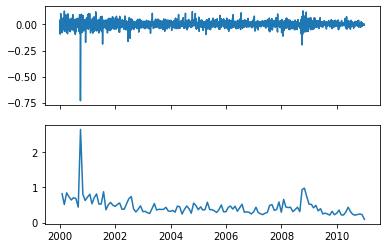

In [73]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df.log_rtn)
ax[1].plot(df_rv.rv)